In [15]:
cd /content/drive/MyDrive/acds3-wildfire-logan

/content/drive/MyDrive/acds3-wildfire-logan


In [16]:
ls

 Ferguson_fire_background.npy  'Ferguson_fire_train (1).npy'   vae_functions.py
 Ferguson_fire_obs.npy          Ferguson_fire_train.npy        vae_model.pth
 Ferguson_fire_test.npy         __pycache__/                   vae.py


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset

## Load and Reshape the Data

In [2]:
# load the training data
train_dataset = np.load("../../Data/Ferguson_fire_train.npy", mmap_mode='r')
print(f"Before reshaping: {np.shape(train_dataset)}")
original_shape = train_dataset.shape[1:]  # Store the original shape

Before reshaping: (12500, 256, 256)


In [3]:
# load the test data
test_dataset = np.load("../../Data/Ferguson_fire_test.npy") #, mmap_mode='r')
print(f"Before reshaping: {np.shape(test_dataset)}")

Before reshaping: (5000, 256, 256)


## Undersample by disregarding cycles where no wildfire develops

In [4]:
# Function to check for cycle lengths based on significant differences between images
def detect_cycles(data, threshold=0.1):
    differences = []
    cycle_indices = []

    for i in range(1, len(data)):
        diff = np.mean(np.abs(data[i] - data[i - 1]))
        differences.append(diff)
        if diff > threshold:
            cycle_indices.append(i)

    return differences, cycle_indices

# # Detect cycles in your dataset
# differences, train_cycle_indices = detect_cycles(train_dataset, threshold=0.1)
# differences, test_cycle_indices = detect_cycles(test_dataset, threshold=0.1)
# print(f"Number of train detected cycles: {len(train_cycle_indices)}")
# print(f"train cycle start indices: {train_cycle_indices}")

# print(f"Number of test detected cycles: {len(test_cycle_indices)}")
# print(f"test cycle start indices: {test_cycle_indices}")

train_cycle_indices = [ i for i in range(0, len(train_dataset), 100)]
print(f"Number of train detected cycles: {len(train_cycle_indices)}")
print(f"train cycle start indices: {train_cycle_indices}")

test_cycle_indices = [ i for i in range(0, len(test_dataset), 100)]
print(f"Number of test detected cycles: {len(test_cycle_indices)}")
print(f"test cycle start indices: {test_cycle_indices}")


Number of train detected cycles: 125
train cycle start indices: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400]
Number of test detected cycles: 50
test cycle start indices: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 20

In [5]:
# Function to create t and t+1 pairs from the dataset based on cycle start indices
def create_pairs(data, cycle_start_indices):
    pairs = []
    for start_idx in cycle_start_indices:
        cycle_end_idx = start_idx + 100  # Assuming each cycle is 100 images long
        # only get each 10th image
        for i in range(start_idx, cycle_end_idx, 10):
            if i + 10 < cycle_end_idx:  # Ensure we don't cross the cycle boundary
                pair = (data[i], data[i + 10])
                pairs.append(pair)
    return np.array(pairs)

# Create pairs from the dataset
train_pairs = create_pairs(train_dataset, train_cycle_indices)
val_pairs = create_pairs(test_dataset, test_cycle_indices)
print(f"Number of train pairs created: {len(train_pairs)}")
print(f"Shape of train pairs: {train_pairs.shape}")

print(f"Number of val pairs created: {len(val_pairs)}")
print(f"Shape of val pairs: {val_pairs.shape}")

Number of train pairs created: 1125
Shape of train pairs: (1125, 2, 256, 256)
Number of val pairs created: 450
Shape of val pairs: (450, 2, 256, 256)


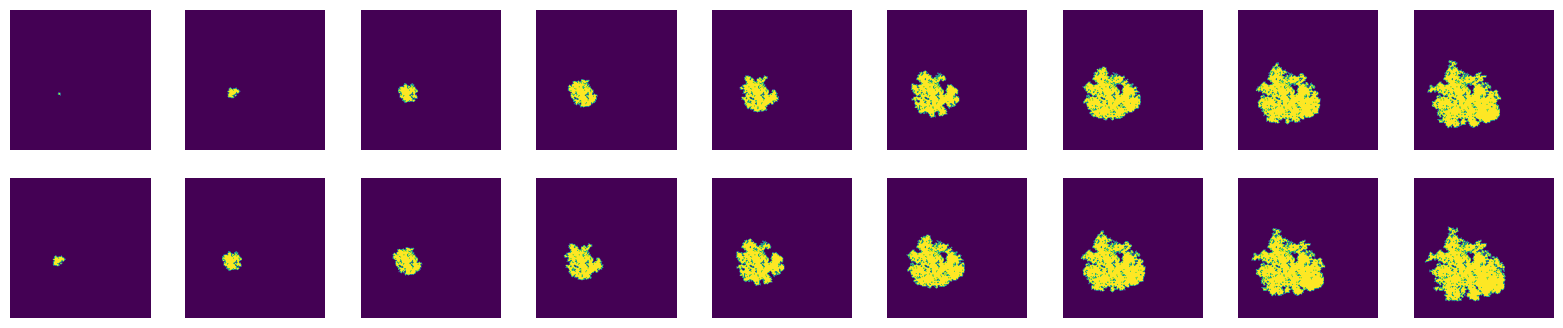

In [6]:
# plot the first 10 pairs
fig, axs = plt.subplots(2, 9, figsize=(20, 4))
for i in range(9):
    axs[0, i].imshow(train_pairs[i+900][0])
    axs[1, i].imshow(train_pairs[i+900][1])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [7]:
# Create the training and validation datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(train_pairs[:, 0], dtype=torch.float32), torch.tensor(train_pairs[:, 1], dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_pairs[:, 0], dtype=torch.float32), torch.tensor(val_pairs[:, 1], dtype=torch.float32))

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=9, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

for images_t, images_t1 in train_loader:
    print('Train t data shape:', images_t.shape)
    print('Train t+1 data shape:', images_t1.shape)
    break

print(f'length of dataloader: {len(train_loader)}')

Number of training samples: 1125
Number of validation samples: 450
Number of training batches: 125
Number of validation batches: 50
Train t data shape: torch.Size([9, 256, 256])
Train t+1 data shape: torch.Size([9, 256, 256])
length of dataloader: 125


In [13]:
# import torch
# from torch import nn, optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

# class VAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim=256, latent_dim=32):
#         super(VAE, self).__init__()

#         # Encoder
#         self.fc1 = nn.Linear(input_dim, 32*32)
#         self.fc2 = nn.Linear(32*32, hidden_dim)
#         self.fc31 = nn.Linear(hidden_dim, latent_dim)
#         self.fc32 = nn.Linear(hidden_dim, latent_dim)
#         self.dropout = nn.Dropout(p=0.2)

#         # Decoder
#         self.fc4 = nn.Linear(latent_dim, hidden_dim)
#         self.fc5 = nn.Linear(hidden_dim, 32*32)
#         self.fc6 = nn.Linear(32*32, input_dim)

#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         h1 = F.relu(self.fc2(h1))
#         h1 = self.dropout(h1)
#         return self.fc31(h1), self.fc32(h1)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h4 = F.relu(self.fc4(z))
#         h4 = F.relu(self.fc5(h4))
#         h4 = self.dropout(h4)
#         return torch.sigmoid(self.fc6(h4))

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar

# def loss_function(recon_x, x, mu, logvar, alpha=1.0, beta=1.0):
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return alpha * BCE + beta * KLD

In [8]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.dropout = nn.Dropout(p=0.2)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = self.dropout(h1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, alpha=1.0, beta=2.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return alpha * BCE + beta * KLD


In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, optimizer, and loss function
input_dim = train_dataset[0][0].numel()  # Flattened image size
print(f"Input dimension: {input_dim}")
hidden_dim = 128
latent_dim = 16

model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3) #best so far: e-3

Input dimension: 65536


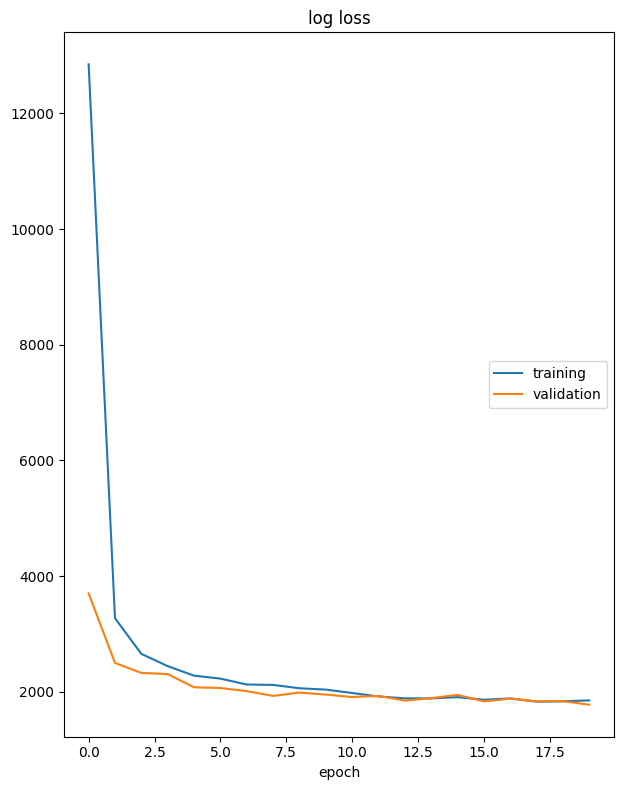

log loss
	training         	 (min: 1828.442, max: 12846.615, cur: 1850.805)
	validation       	 (min: 1776.236, max: 3701.021, cur: 1776.236)
Epoch 20, Training loss: 1850.8047, Validation loss: 1776.2364


In [10]:
# Training and validation loops

from livelossplot import PlotLosses

num_epochs = 20
train_losses = []
val_losses = []
liveloss = PlotLosses()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

def train(epoch, model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)  # Flatten the input images
        target = target.view(target.size(0), -1).to(device)  # Flatten the target images
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    return avg_train_loss

def validate(epoch, model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.view(data.size(0), -1).to(device)  # Flatten the input images
            target = target.view(target.size(0), -1).to(device)  # Flatten the target images
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, target, mu, logvar)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss

for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch, model, train_loader, optimizer, device)
    val_loss = validate(epoch, model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': val_loss
    })
    liveloss.draw()
    print(f"Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")


In [11]:
from torchsummary import summary

summary(model, (input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]       8,388,736
           Dropout-2                  [-1, 128]               0
            Linear-3                   [-1, 16]           2,064
            Linear-4                   [-1, 16]           2,064
            Linear-5                  [-1, 128]           2,176
            Linear-6                [-1, 65536]       8,454,144
Total params: 16,849,184
Trainable params: 16,849,184
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.50
Params size (MB): 64.27
Estimated Total Size (MB): 65.03
----------------------------------------------------------------


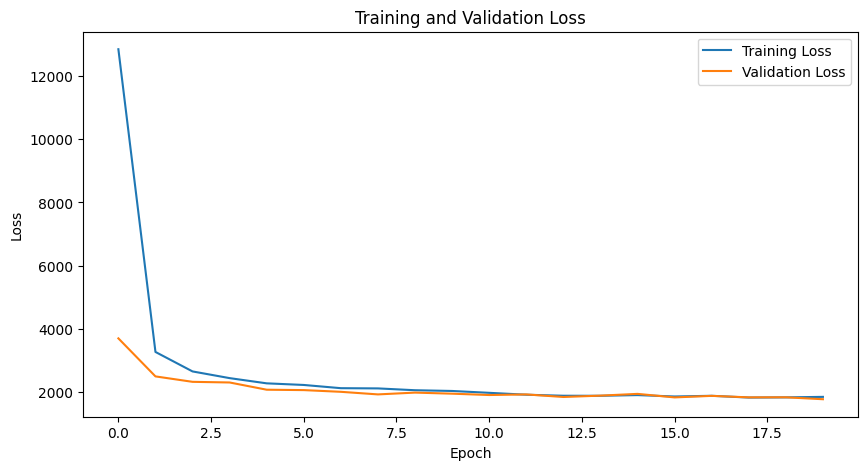

In [12]:
# Plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# save the model and model state dict
torch.save(model, '../../Model/linearvae.pth')
torch.save(model.state_dict(), '../../Model/linearvae_state_dict.pth')

## Generate random images

Latent dimension: 16
Shape of generated images: (99, 65536)


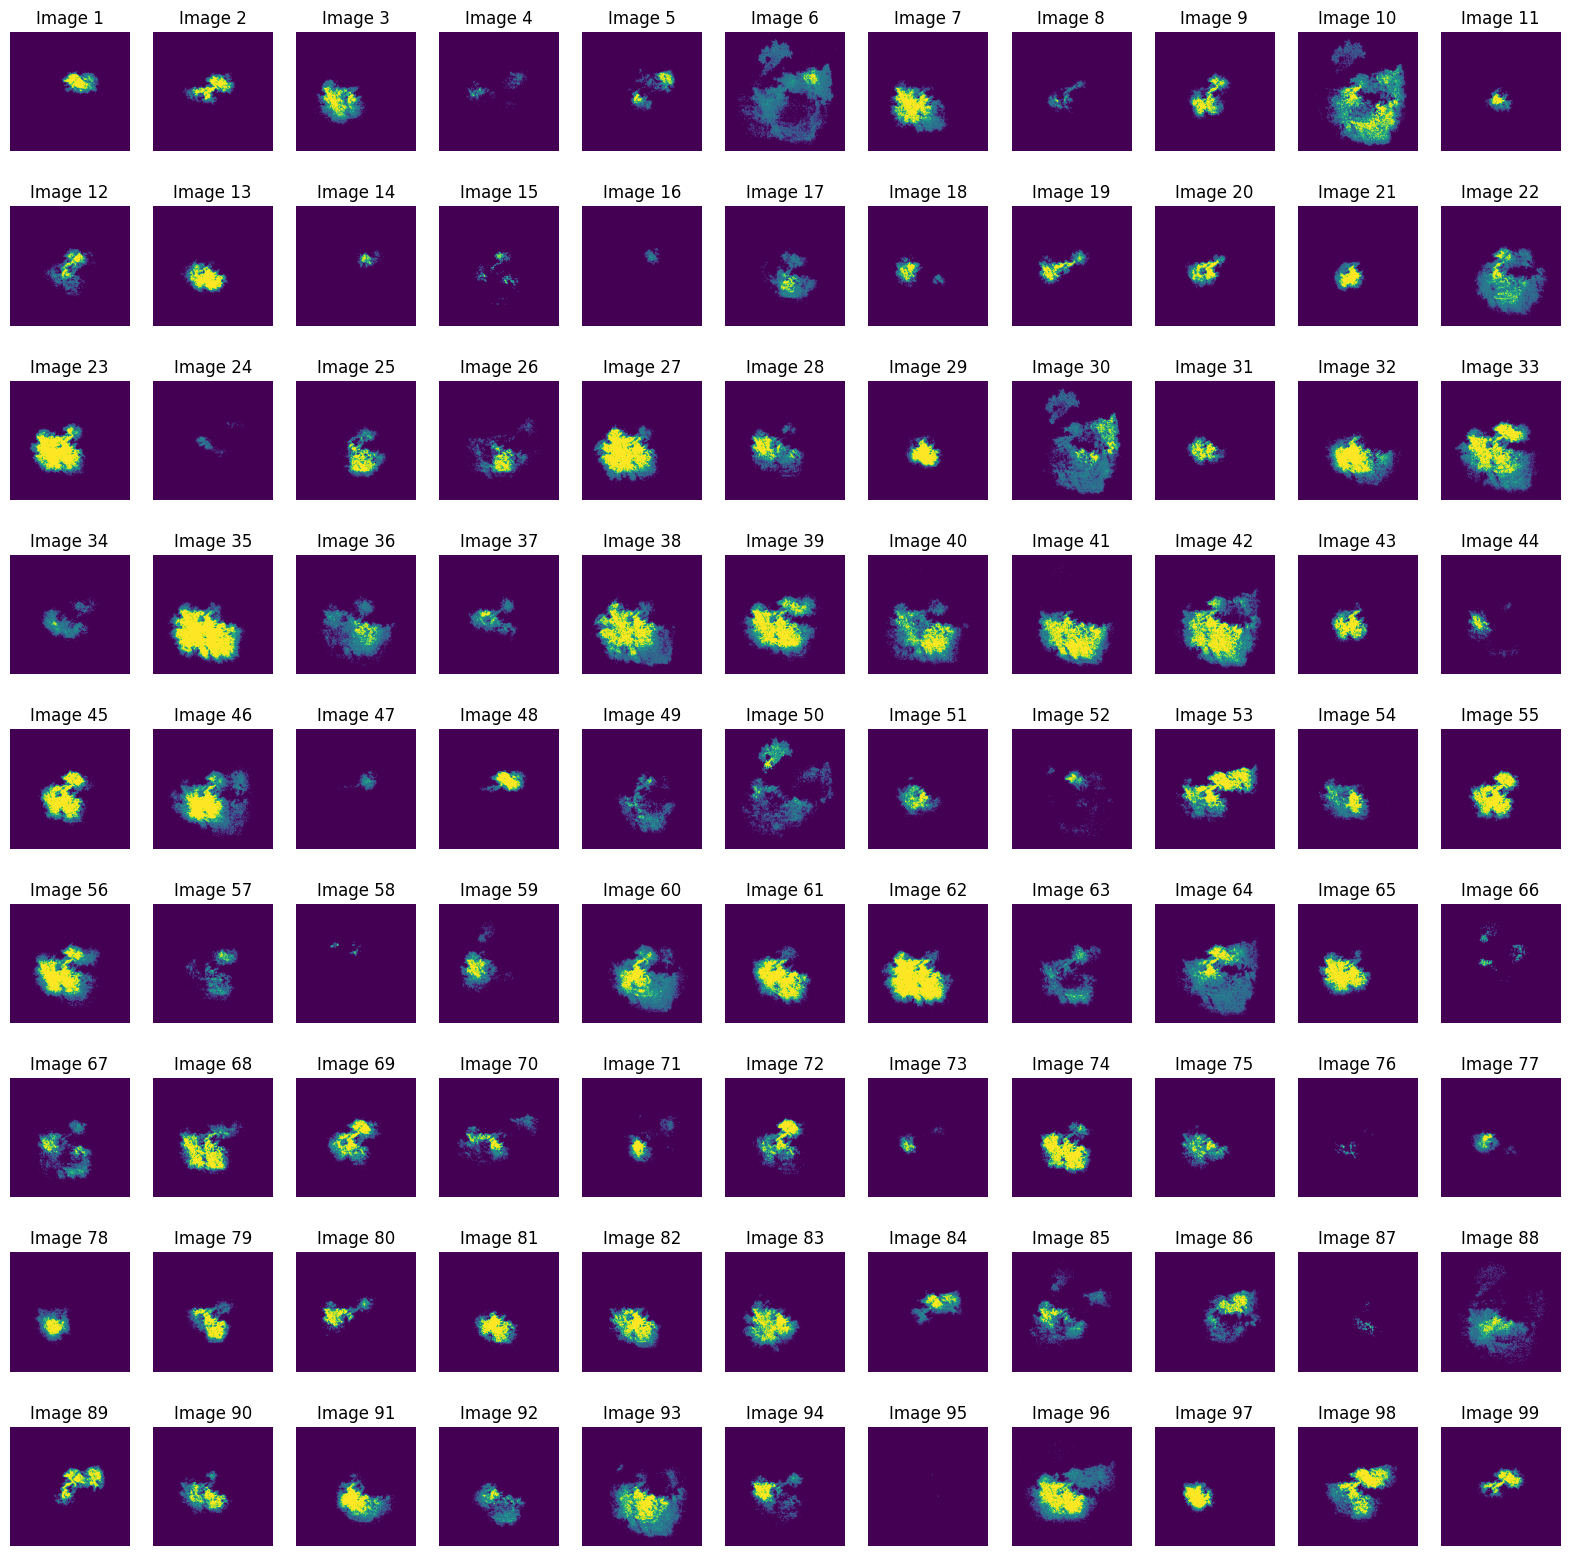

In [14]:
# Number of images to generate
num_images = 99

# Sample latent vectors z from the standard normal distribution
latent_dim = model.fc21.out_features  # Ensure this matches the latent dimension of your model
print(f"Latent dimension: {latent_dim}")
z = torch.randn(num_images, latent_dim).to(device)

# Generate images from the latent vectors
with torch.no_grad():
    generated_images = model.decode(z).cpu().numpy()

print(f"Shape of generated images: {generated_images.shape}")

threshold_low = 0.3
threshold_high = 0.5
generated_images[generated_images < threshold_low] = 0
generated_images[generated_images > threshold_high] = 1

# Reshape the generated images to their original dimensions
generated_images = generated_images.reshape(num_images, 256, 256)  # Adjust to your image dimensions

# Plot the 100 generated images
fig, axes = plt.subplots(9, 11, figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(generated_images[i])
    ax.axis('off')
    ax.set_title(f'Image {i + 1}')


## find the one with lowest mse

In [15]:
satellite_data = np.load("../../Data/Ferguson_fire_obs.npy", mmap_mode='r') 

Min MSE: 0.032639077629141436
Generated Image Index with Min MSE: 1
Satellite Image Index with Min MSE: 0


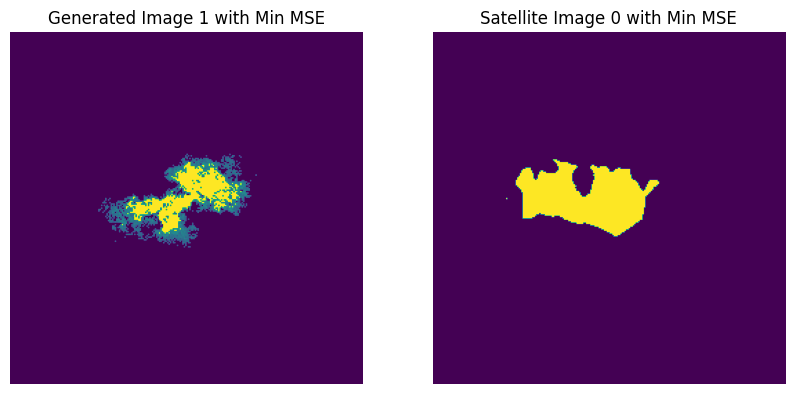

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

min_mse = float('inf')
min_mse_generated_image = None
min_mse_satellite_image = None
min_mse_gen_idx = 0
min_mse_sat_idx = 0

for i, gen_img in enumerate(generated_images):
    for j, satellite_img in enumerate(satellite_data):
        mse = mean_squared_error(gen_img.flatten(), satellite_img.flatten())
        if mse < min_mse:
            min_mse = mse
            min_mse_generated_image = gen_img
            min_mse_satellite_image = satellite_img
            min_mse_gen_idx = i
            min_mse_sat_idx = j

print(f"Min MSE: {min_mse}")
print(f"Generated Image Index with Min MSE: {min_mse_gen_idx}")
print(f"Satellite Image Index with Min MSE: {min_mse_sat_idx}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(min_mse_generated_image)
axs[0].set_title(f'Generated Image {min_mse_gen_idx} with Min MSE')
axs[0].axis('off')

axs[1].imshow(min_mse_satellite_image)
axs[1].set_title(f'Satellite Image {min_mse_sat_idx} with Min MSE')
axs[1].axis('off')

plt.show()


## Generate data with time steps

1st generated from latent space, then put 1st into model to have the 2nd

In [70]:
def generate_sequence(model, initial_latent_vector, num_steps, device):
    model.eval()
    generated_images = []
    z = initial_latent_vector.to(device)
    
    with torch.no_grad():
        for _ in range(num_steps):
            generated_image = model.decode(z)
            generated_images.append(generated_image.view(256, 256).cpu().numpy())
            
            generated_image_flat = generated_image.view(1, -1)
            # threshold_low = 0.3
            # threshold_high = 0.3
            # generated_image_flat[generated_image_flat < threshold_low] = 0
            # generated_image_flat[generated_image_flat > threshold_high] = 1
            mu, logvar = model.encode(generated_image_flat)
            z = model.reparameterize(mu, logvar)
    
    return generated_images

latent_dim = 16  # Ensure this matches the latent dimension of your model
initial_latent_vector = torch.randn(1, latent_dim).to(device)

num_steps = 9  # Number of images to generate in the sequence
generated_images = generate_sequence(model, initial_latent_vector, num_steps, device)


Shape of generated images: (9, 256, 256)


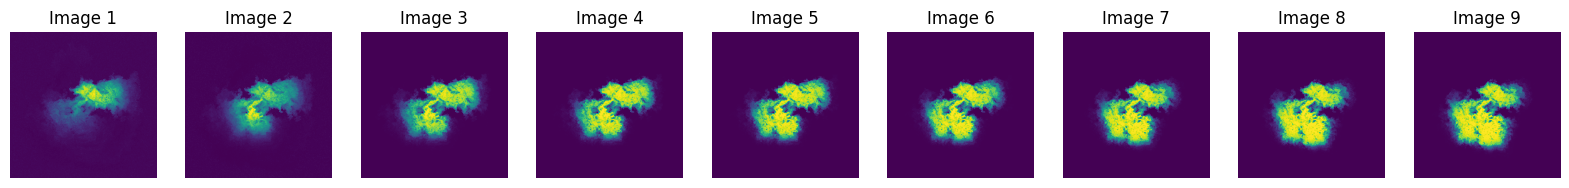

In [71]:
# Apply threshold to the generated images
# threshold_low = 0.01
# threshold_high = 0.001
# generated_images = np.array(generated_images)
# generated_images[generated_images < threshold_low] = 0
# generated_images[generated_images > threshold_high] = 1

print(f"Shape of generated images: {np.shape(generated_images)}")

fig, axes = plt.subplots(1, 9, figsize=(20, 2))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(generated_images[i])
    ax.axis('off')
    ax.set_title(f'Image {i + 1}')



Min MSE: 0.040063921534229385
Generated Image Index with Min MSE: 1
Satellite Image Index with Min MSE: 1


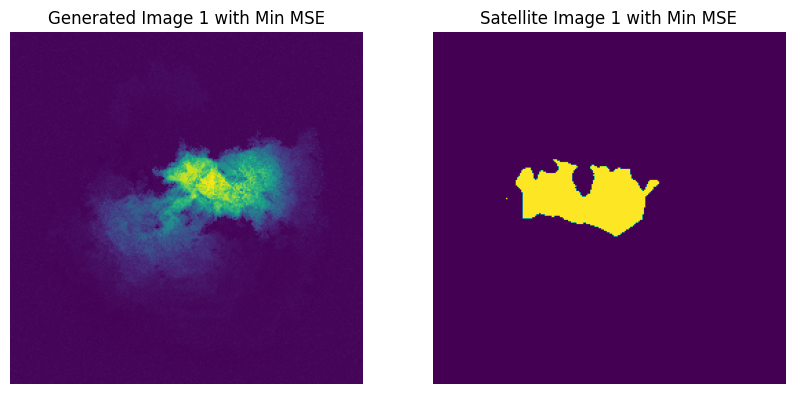

In [72]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

min_mse = float('inf')
min_mse_generated_image = None
min_mse_satellite_image = None
min_mse_gen_idx = 0
min_mse_sat_idx = 0

for i, gen_img in enumerate(generated_images):
    for j, satellite_img in enumerate(satellite_data):
        mse = mean_squared_error(gen_img.flatten(), satellite_img.flatten())
        if mse < min_mse:
            min_mse = mse
            min_mse_generated_image = gen_img
            min_mse_satellite_image = satellite_img
            min_mse_gen_idx = i + 1
            min_mse_sat_idx = j + 1

print(f"Min MSE: {min_mse}")
print(f"Generated Image Index with Min MSE: {min_mse_gen_idx}")
print(f"Satellite Image Index with Min MSE: {min_mse_sat_idx}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(min_mse_generated_image)
axs[0].set_title(f'Generated Image {min_mse_gen_idx} with Min MSE')
axs[0].axis('off')

axs[1].imshow(min_mse_satellite_image)
axs[1].set_title(f'Satellite Image {min_mse_sat_idx} with Min MSE')
axs[1].axis('off')

plt.show()


## Save the image for calculating MSE

In [73]:
np.save('../../Data/min_mse_generated_image.npy', min_mse_generated_image)

## Save 5 images started from the min_mse_gen_idx for DA

In [74]:
# save the five generated images started from the min_mse_gen_idx in a .npy
np.save('../../Data/min_mse_5generated_images.npy', generated_images[min_mse_gen_idx-1-(min_mse_sat_idx-1):min_mse_gen_idx+4-(min_mse_sat_idx-1)])

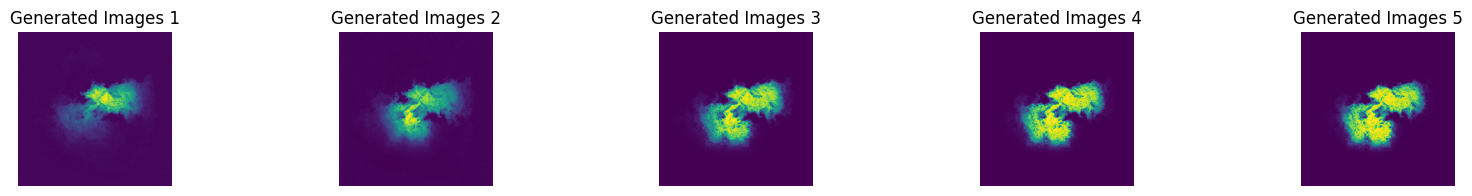

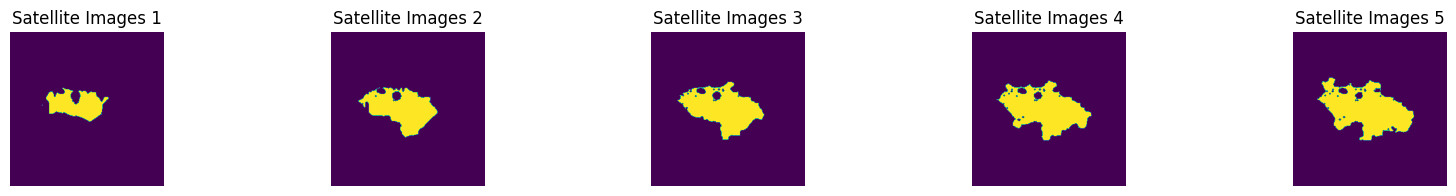

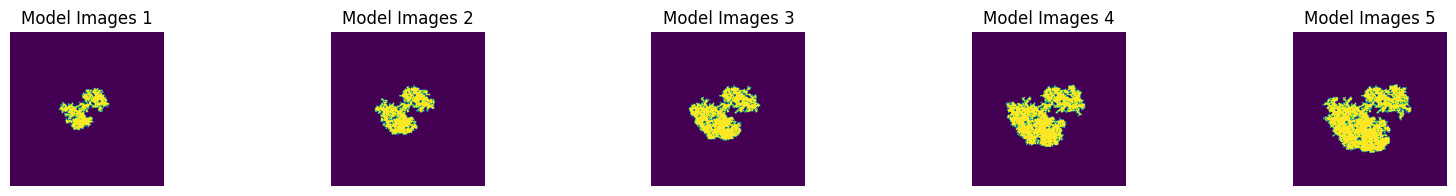

In [75]:

# load and plot the min_mse_5generated_images.npy and satellite images
min_mse_5generated_images = np.load('../../Data/min_mse_5generated_images.npy')

fig, axs = plt.subplots(1, 5, figsize=(20, 2))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(min_mse_5generated_images[i])
    ax.axis('off')
    ax.set_title(f'Generated Images {i + 1}')

fig, axs = plt.subplots(1, 5, figsize=(20, 2))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(satellite_data[i])
    ax.axis('off')
    ax.set_title(f'Satellite Images {i + 1}')

model_data = np.load('../../Data/Ferguson_fire_background.npy')
fig, axs = plt.subplots(1, 5, figsize=(20, 2))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(model_data[i])
    ax.axis('off')
    ax.set_title(f'Model Images {i + 1}')

